#Sistema de recomendação para trabalhos acadêmicos

Produzido por Hadênia Rodrigues

# Configuração de Ambiente

In [ ]:
!pip install openai
!pip install --upgrade tiktoken
!pip install opentsne
!pip install pymupdf
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 2.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 27.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 49.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# imports
import tiktoken
import pandas as pd
import numpy as np
from openai.embeddings_utils import get_embedding, cosine_similarity
import matplotlib.pyplot as plt
import matplotlib
from sklearn.manifold import TSNE
import openTSNE

# Coleta de Dados

##### Os dados coletados utilizados nesse trabalho foram capturas através de script Web Sraping do Repositorio da UFRN. Os dados são referentes aos trabalhos acadêmicos do Programa de Pós-Graduação em Engenharia Elétrica e de Computação (PPGEEC), estão contidos teses de doutorado e dissertações de mestrado.

**Referências:**
* Reposiório UFRN https://repositorio.ufrn.br/handle/123456789/11949
* Web Scraping https://docs.scrapy.org/en/latest/intro/tutorial.html

##Importação dos dados

In [ ]:
import pandas as pd

In [ ]:
df_dissertacoes = pd.read_csv('doc_dissertacoes.csv') #Importando dados de dissertações de mestrado

df_teses = pd.read_csv('doc_teses.csv') #Importando dados da teses de doutorado

df_publicacoes = pd.concat([df_dissertacoes, df_teses]) #Concatenação de ambos em um só dataset

In [ ]:
df_publicacoes.to_csv("publicacoes_ppgeec.csv",index=False) #exportando dataset publicacoes para arquivo csv

In [ ]:
df_publicacoes.head()

,titulo,autor,link,abstract,resumo
0,Moduladores Sigma-Delta passa-banda programáve...,"Lima, Evelyn Cristina de Oliveira",https://repositorio.ufrn.br/handle/123456789/5...,No Rádio Definido por Software (SDR) a maioria...,No Rádio Definido por Software (SDR) a maioria...
1,Contribuições na estratégia de controle por mo...,"Sousa, Alan Rodrigues de",https://repositorio.ufrn.br/handle/123456789/5...,"Distributed generation systems, which use rene...",Os sistemas de geração distribuída que utiliza...
2,Dispositivos internos para coleta automática d...,"Bezerra, Arthur Andrade",https://repositorio.ufrn.br/handle/123456789/5...,"This work intends to present the development, ...","Este trabalho propõe o desenvolvimento, calibr..."
3,Avaliação energética e alternativas de abastec...,"Silva, Neilton Fidelis da",https://repositorio.ufrn.br/handle/123456789/4...,The pourpose of this work is to analyse the en...,O presente trabalho tem por objetivo analisar ...
4,Block uma ferramenta para reconhecimento e blo...,"Amaral, Flávio Marcelo Cavalcante Bandeira do",https://repositorio.ufrn.br/handle/123456789/4...,Operating Systems and hosts connected to netwo...,Os sistemas operacionais e as máquinas em rede...


In [ ]:
df_publicacoes.shape

(850, 5)

## Analise dos dados
Verificação de quantidade de linhas nulas

In [ ]:
df_publicacoes.isnull().sum()

titulo       0
autor        0
link         0
abstract    43
resumo       0
dtype: int64

##  Criação de nova coluna
União de colunas "Título" e "Resumo".

In [ ]:
df_publicacoes["combinacao"] = "Título: " + df_publicacoes.titulo.str.strip() + "; Resumo: " + df_publicacoes.resumo.str.strip()

In [ ]:
df_publicacoes.head()

,titulo,autor,link,abstract,resumo,combinacao
0,Moduladores Sigma-Delta passa-banda programáve...,"Lima, Evelyn Cristina de Oliveira",https://repositorio.ufrn.br/handle/123456789/5...,No Rádio Definido por Software (SDR) a maioria...,No Rádio Definido por Software (SDR) a maioria...,Título: Moduladores Sigma-Delta passa-banda pr...
1,Contribuições na estratégia de controle por mo...,"Sousa, Alan Rodrigues de",https://repositorio.ufrn.br/handle/123456789/5...,"Distributed generation systems, which use rene...",Os sistemas de geração distribuída que utiliza...,Título: Contribuições na estratégia de control...
2,Dispositivos internos para coleta automática d...,"Bezerra, Arthur Andrade",https://repositorio.ufrn.br/handle/123456789/5...,"This work intends to present the development, ...","Este trabalho propõe o desenvolvimento, calibr...",Título: Dispositivos internos para coleta auto...
3,Avaliação energética e alternativas de abastec...,"Silva, Neilton Fidelis da",https://repositorio.ufrn.br/handle/123456789/4...,The pourpose of this work is to analyse the en...,O presente trabalho tem por objetivo analisar ...,Título: Avaliação energética e alternativas de...
4,Block uma ferramenta para reconhecimento e blo...,"Amaral, Flávio Marcelo Cavalcante Bandeira do",https://repositorio.ufrn.br/handle/123456789/4...,Operating Systems and hosts connected to netwo...,Os sistemas operacionais e as máquinas em rede...,Título: Block uma ferramenta para reconhecimen...


In [ ]:
df_publicacoes["combinacao"].head()

0    Título: Moduladores Sigma-Delta passa-banda pr...
1    Título: Contribuições na estratégia de control...
2    Título: Dispositivos internos para coleta auto...
3    Título: Avaliação energética e alternativas de...
4    Título: Block uma ferramenta para reconhecimen...
Name: combinacao, dtype: object

**Observação**
* Percebido que coluna abstract apresentava linhas nulas, por isso será utilizado a coluna "resumo" do que "abstract".
A coluna abstract poderia ser utilizada, porém ao excluir linhas nulas, perderiamos dados.


# Tokenização

Para processar texto será necessário a ténica de tokenização que consiste em transforma sequencia de caracteres em tokens.
Será utilizado o modelo text-embedding-ada-002 que custa $0.0004 / 1K tokens . Modelo de Embedding da API-OpenIA .

## Autenticação em OpenIA

Para utilização da API de OpenIA é necessário a autenticação através chave. Para obter é só preciso realizar o cadastro do site da openIA, a seguir
https://platform.openai.com/docs/api-reference/authentication .
Utilizei a minha chave através de um arquivo chamado key.txt

In [ ]:
!pip install openai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Open the file in read mode
with open("key.txt", "r") as file:
    # Read the entire content of the file
    key = file.read()

In [ ]:
# Import necessary libraries to interact with the OpenAI API
import os
import openai

# Set the OpenAI API key for authentication
openai.api_key = key

In [ ]:
pip install git+https://github.com/openai/whisper.git

## Transformando texto em token

In [ ]:
import tiktoken

In [ ]:
embedding_encoding = "cl100k_base"
encoding = tiktoken.get_encoding(embedding_encoding)

In [ ]:
encoding.encode("Sistema de recomendação para trabalhos acadêmicos")

[50, 42548, 409, 38301, 9895, 6027, 3429, 37368, 42935, 10623, 39930, 17038]

In [ ]:
encoding.decode([50, 42548, 409, 38301, 9895, 6027, 3429, 37368, 42935, 10623, 39930, 17038])

'Sistema de recomendação para trabalhos acadêmicos'

## Quantidade de Tokens
Foi criado uma coluna chamada "n_tokens" para verifica a quantidade e tokens em cada linha da coluna "combinação"

In [ ]:
# embedding model parameters
embedding_model = "text-embedding-ada-002"
embedding_encoding = "cl100k_base"  # this the encoding for text-embedding-ada-002
max_tokens = 8191  # the maximum for text-embedding-ada-002 is 8191

In [ ]:
#Calcula o numero de tokens para cada celula da coluna "Combinacao"

embedding_encoding = "cl100k_base"
encoding = tiktoken.get_encoding(embedding_encoding)
df_publicacoes["n_tokens"] = df_publicacoes.combinacao.apply(lambda x: len(encoding.encode(x)))

In [ ]:
print(f"Preço estimado U$ {(df_publicacoes.n_tokens.sum()/1000*0.0004)}.")

Preço estimado U$ 0.1526412.


## Tokenização da base dados

* Criado nova coluna chamada "embedding" onde armazena os tokens.
* Processado apenas 1 vez e gerado o arquivo "publicacoes_ppgeec_embeddings.csv" . Não será mais necessário compilar novamente.
* Demorou em media 12 minutos e custou R$ 0,15

In [ ]:
embedding_model = "text-embedding-ada-002"

In [ ]:
df_publicacoes["embedding"] = df_publicacoes.combinacao.apply(lambda x: get_embedding(x, engine=embedding_model))

In [ ]:
# Export the output into a .csv file
 df_publicacoes.to_csv("publicacoes_ppgeec_embeddings.csv",index=False)

# Sistema de recomendação

Importar csv criado, com a coluna de tokenização

In [ ]:
!pip install openai

In [ ]:
import pandas as pd
import numpy as np
from openai.embeddings_utils import get_embedding, cosine_similarity

In [ ]:
datafile_path = "publicacoes_ppgeec_embeddings.csv"
df = pd.read_csv(datafile_path)

In [ ]:
#Converte a coluna de strings representadas por listas de numeros (os embeddings) na coluna de NumPy arrays
df["embedding"] = df.embedding.apply(eval).apply(np.array)

In [ ]:
df.head()

,titulo,autor,link,abstract,resumo,combinacao,n_tokens,embedding
0,Moduladores Sigma-Delta passa-banda programáve...,"Lima, Evelyn Cristina de Oliveira",https://repositorio.ufrn.br/handle/123456789/5...,No Rádio Definido por Software (SDR) a maioria...,No Rádio Definido por Software (SDR) a maioria...,Título: Moduladores Sigma-Delta passa-banda pr...,561,"[0.0007355875568464398, 0.010268514044582844, ..."
1,Contribuições na estratégia de controle por mo...,"Sousa, Alan Rodrigues de",https://repositorio.ufrn.br/handle/123456789/5...,"Distributed generation systems, which use rene...",Os sistemas de geração distribuída que utiliza...,Título: Contribuições na estratégia de control...,594,"[-0.024726253002882004, -0.0032372234854847193..."
2,Dispositivos internos para coleta automática d...,"Bezerra, Arthur Andrade",https://repositorio.ufrn.br/handle/123456789/5...,"This work intends to present the development, ...","Este trabalho propõe o desenvolvimento, calibr...",Título: Dispositivos internos para coleta auto...,274,"[-0.02059972658753395, 0.019845256581902504, 0..."
3,Avaliação energética e alternativas de abastec...,"Silva, Neilton Fidelis da",https://repositorio.ufrn.br/handle/123456789/4...,The pourpose of this work is to analyse the en...,O presente trabalho tem por objetivo analisar ...,Título: Avaliação energética e alternativas de...,486,"[-0.00012822618009522557, -0.00828647334128618..."
4,Block uma ferramenta para reconhecimento e blo...,"Amaral, Flávio Marcelo Cavalcante Bandeira do",https://repositorio.ufrn.br/handle/123456789/4...,Operating Systems and hosts connected to netwo...,Os sistemas operacionais e as máquinas em rede...,Título: Block uma ferramenta para reconhecimen...,235,"[-0.0294553991407156, -0.0019299308769404888, ..."


## Sistema de Recomendação

In [ ]:
# Função para pesquisar em um artigo semelhante

In [ ]:
def search_papers(dataframe, paper_description, n=3, pprint=True):
    df = dataframe.copy()
    paper_embedding = get_embedding(paper_description,
                                    engine="text-embedding-ada-002"
                                    )
    df["similaridade"] = df.embedding.apply(lambda x: cosine_similarity(x, paper_embedding))
    results = df.sort_values("similaridade", ascending=False).head(n).combinacao.str.replace("Titulo: ", "").str.replace("; Resumo:", ": ")

    return results

# Exemplo com título

In [ ]:
result = search_papers(df,"""Reconhecimento de caracteres utilizando redes neurais
                       convolucionais para auxiliar nas correções do sistema multiprova""", 5, True)
result

504    Título: ﻿Detecção e isolamento de falhas em si...
391    Título: Reconhecimento de padrões de falhas em...
379    Título: Utilização de redes neurais artificiai...
456    Título: Identificação remota de sistemas opera...
837    Título: Reconhecimento de voz através de unida...
Name: combinacao, dtype: object

In [ ]:
result.loc[504]

'Título: \ufeffDetecção e isolamento de falhas em sistemas dinâmicos baseados em redes neurais:  \ufeffEsta dissertação de mestrado apresenta o desenvolvimento de um sistema de detecção e isolamento de falhas (DIF) baseado em redes neurais. O sistema é dividido em duas \t \r\netapas: uma de identificação neural do sistema e outra de detecção e classificação de \tfalhas. Ambos subsistemas usam técnicas de redes neurais com o algoritmoBackpropa-\t \r\ngation para redes Perceptronde Múltiplas Camadas. Duas abordagens para identificação neural foram testadas e uma delas selecionada para fazer parte do sistema DIF. Oclassifi-cador de falhas utiliza apenas valores residuais para a classificação das mesmas. Todos os testes foram realizados tanto em ambiente simulado quanto em ambiente real, no intuito de comprovar dificuldades encontradas em testes reais não existentes quando se trabalha apenas com simulações'

In [ ]:
result.loc[391]

'Título: Reconhecimento de padrões de falhas em motores trifásicos utilizando redes neurais:  Este trabalho apresenta um sistema de diagnóstico de falhas (rotor, estator e contaminação)\ndo motor de indução trifásico através dos parâmetros do circuito equivalente e\nutilizando técnicas de reconhecimento de padrões. A tecnologia de detecção de falhas em\nmotores está evoluindo e tornando cada vez mais importante na área de máquinas elétricas.\nAs redes neurais possuem a habilidade de classificar relações não lineares entre sinais\natravés da identificação de padrões dos sinais relacionados. São realizados simulações do\nmotor de indução através do programa Matlab R\n & Simulink R\n e produzido alguns tipos\nde falhas no conjunto a partir de modificações nos parâmetros do circuito equivalente. É\nimplementado um sistema com múltiplos classificadores neurais para receber estes resultados\ne, após o treinamento, realizar a identificação dos padrões de falhas'

In [ ]:
result.loc[379]

'Título: Utilização de redes neurais artificiais para detecção e diagnóstico de falhas:  &#65279;Em um processo real, todos os recursos utilizados, sejam físicos ou desenvolvidos em \t \nsoftware, estão sujeitos a interrupções ou a comprometimentos operacionais. Contudo, \t \nnas situações em que operam os sistemas críticos, qualquer tipo de problema pode vir a \t \ntrazer grandes consequências. Sabendo disso, este trabalho se propõe a desenvolver um \t \nsistema capaz de detectar a presença e indicar os tipos de falhas que venham a ocorrer \t \nem um determinado processo. Para implementação e testes da metodologia proposta, um \t \nsistema de tanques acoplados foi escolhido como modelo de estudo de caso. O sistema \t \ndesenvolvido deverá gerar um conjunto de sinais que notifiquem o operador do processo \t \ne que possam vir a ser pós-processados, possibilitando que sejam feitas alterações nas \t \nestratégias ou nos parâmetros dos controladores. Em virtude dos riscos envolvidos com \

# Consulta 1

In [ ]:
paper = """Reconhecimento de caracteres utilizando redes neurais convolucionais para auxiliar nas correções do sistema multiprova.
O software Multiprova foi muito utilizado durante os períodos de ensino remoto na Universidade Federal do Rio Grande do Norte
(UFRN), com a volta presencial das aulas o processo de correção de provas precisou ser melhorado para facilitar a adaptação do
sistema às aulas presenciais, uma dessas melhorias foi a correção automática de cartões respostas dos alunos. O reconhecimento
ótico de caracteres é uma técnica recente muito utilizada para máquinas realizarem a leitura de textos escrito por humanos.
O objetivo central do trabalho é desenvolver um processo de reconhecimento de caracteres manuscritos a fim de
melhorar e facilitar a correção de provas no software Multiprova. Para essa finalidade foram utilizadas redes neurais
convolucionais para realizar essa tarefa. Com a coleta de imagens feitas pelos próprios alunos da UFRN, foram analisados
e comparados cenários diferentes com o incremento das configurações das redes com o intuito de gerar redes neurais com as
melhores taxas de precisão. Com isso foram obtidos ótimos níveis de acurácia, permitindo alta confiabilidade no software e
mais segurança e facilidade na correção das provas."""
result = search_papers(df,paper,5, False)
result

379    Título: Utilização de redes neurais artificiai...
456    Título: Identificação remota de sistemas opera...
508    Título: Algoritmos inteligentes para auto-corr...
391    Título: Reconhecimento de padrões de falhas em...
837    Título: Reconhecimento de voz através de unida...
Name: combinacao, dtype: object

In [ ]:
result.loc[379]

'Título: Utilização de redes neurais artificiais para detecção e diagnóstico de falhas:  &#65279;Em um processo real, todos os recursos utilizados, sejam físicos ou desenvolvidos em \t \nsoftware, estão sujeitos a interrupções ou a comprometimentos operacionais. Contudo, \t \nnas situações em que operam os sistemas críticos, qualquer tipo de problema pode vir a \t \ntrazer grandes consequências. Sabendo disso, este trabalho se propõe a desenvolver um \t \nsistema capaz de detectar a presença e indicar os tipos de falhas que venham a ocorrer \t \nem um determinado processo. Para implementação e testes da metodologia proposta, um \t \nsistema de tanques acoplados foi escolhido como modelo de estudo de caso. O sistema \t \ndesenvolvido deverá gerar um conjunto de sinais que notifiquem o operador do processo \t \ne que possam vir a ser pós-processados, possibilitando que sejam feitas alterações nas \t \nestratégias ou nos parâmetros dos controladores. Em virtude dos riscos envolvidos com \

In [ ]:
result.loc[456]

'Título: Identificação remota de sistemas operacionais utilizando análise de processos aleatórios e redes neurais artificiais:  É proposto um novo método para identificação remota de sistemas operacionais que operam em redes TCP/IP. Este método possui diversas aplicações relacionadas à segurança\nem redes de computadores e é normalmente adotado tanto em atividades de ataque quanto de defesa de sistemas. O método proposto é capaz de obter sucesso em situações\nonde diversas soluções atuais falham, inclusive no tratamento com dispositivos possivelmente vulneráveis ao processo de identificação. O novo método realiza a análise dos\ngeradores de números aleatórios usados nas pilhas TCP/IP e, através do uso de redes neurais artificiais, cria mapas que representam o comportamento destes geradores. Tais\nmapas são usados para comparação com mapas rotulados que representam sistemas já conhecidos, concretizando o processo de identificação'

In [ ]:
result.loc[508]

'Título: Algoritmos inteligentes para auto-correção, auto-verificação e auto-validação de medidas em sensores:  \ufeffNeste trabalho é apresentado um conjunto de algoritmos inteligentes que têm como objetivo a correção de erros de calibração em sensores e a diminuição da periodicidade de suas calibrações. Tais algoritmos foram desenvolvidos utilizando Redes Neurais Artificiais devido a sua grande capacidade de aprendizado, adaptação e aproximação de funções. \tSerão mostradas duas abordagens, a primeira utiliza redes Perceptron de Múltiplas Camadas para aproximar as diversas formas da curva de calibração do sensor que se descalibra em diferentes instantes do tempo. Tal abordagem exige o conhecimento do tempo de funcionamento do sensor, informação que nem sempre \testá disponível. Para superar essa necessidade, uma outra abordagem utilizando \t \r\nRedes Neurais Recorrentes foiproposta. As Redes Recorrentes possuem uma grande capacidade de aprender a dinâmica do sistema para o qual ela 

In [ ]:
result.loc[391]

'Título: Reconhecimento de padrões de falhas em motores trifásicos utilizando redes neurais:  Este trabalho apresenta um sistema de diagnóstico de falhas (rotor, estator e contaminação)\ndo motor de indução trifásico através dos parâmetros do circuito equivalente e\nutilizando técnicas de reconhecimento de padrões. A tecnologia de detecção de falhas em\nmotores está evoluindo e tornando cada vez mais importante na área de máquinas elétricas.\nAs redes neurais possuem a habilidade de classificar relações não lineares entre sinais\natravés da identificação de padrões dos sinais relacionados. São realizados simulações do\nmotor de indução através do programa Matlab R\n & Simulink R\n e produzido alguns tipos\nde falhas no conjunto a partir de modificações nos parâmetros do circuito equivalente. É\nimplementado um sistema com múltiplos classificadores neurais para receber estes resultados\ne, após o treinamento, realizar a identificação dos padrões de falhas'

In [ ]:
result.loc[837]

'Título: Reconhecimento de voz através de unidades menores do que a palavra, utilizando Wavelet Packet e SVM, em uma nova estrutura hierárquica de decisão:  O reconhecimento automático da voz por máquinas inteligentes tem sido a meta de muitos pesquisadores nas últimas cinco décadas. Neste período, inúmeros avanços foram alcançados, como por exemplo no campo de reconhecimento de palavras isoladas (comandos), o qual atualmente apresenta taxas de reconhecimento muito altas. No entanto, ainda se está longe de desenvolver um sistema que possa ter um desempenho parecido com o ser humano, ou seja, reconhecimento automático de voz em modo contínuo. Um dos grandes desafios das pesquisas de reconhecimento de voz contínuo é a grande quantidade de padrões existentes, pois as linguagens modernas tais como: Inglês, Francês,\nEspanhol e Português possuem aproximadamente 500.000 palavras ou padrões a serem identificados.\nA proposta deste trabalho é utilizar unidades menores do que a palavra tais com

## Gráficos - Funcionamento com t-SNE

In [ ]:
!pip install opentsne
from sklearn.manifold import TSNE
import openTSNE
import matplotlib.pyplot as plt

In [ ]:
datafile_path = "publicacoes_ppgeec_embeddings.csv"
df = pd.read_csv(datafile_path)

# Convert to a list of lists of floats
matrix = np.array(df.embedding.apply(eval).to_list())

In [ ]:
# https://github.com/pavlin-policar/openTSNE

# Create a t-SNE model and transform the data into only two components
tsne_new = openTSNE.TSNE(n_components=2, perplexity=15, random_state=42,learning_rate=200)
vis_dims_new = tsne_new.fit(matrix)

In [ ]:
paper = """Reconhecimento de caracteres utilizando redes neurais convolucionais para auxiliar nas correções do sistema multiprova.
O software Multiprova foi muito utilizado durante os períodos de ensino remoto na Universidade Federal do Rio Grande do Norte
(UFRN), com a volta presencial das aulas o processo de correção de provas precisou ser melhorado para facilitar a adaptação do
sistema às aulas presenciais, uma dessas melhorias foi a correção automática de cartões respostas dos alunos. O reconhecimento
ótico de caracteres é uma técnica recente muito utilizada para máquinas realizarem a leitura de textos escrito por humanos.
O objetivo central do trabalho é desenvolver um processo de reconhecimento de caracteres manuscritos a fim de
melhorar e facilitar a correção de provas no software Multiprova. Para essa finalidade foram utilizadas redes neurais
convolucionais para realizar essa tarefa. Com a coleta de imagens feitas pelos próprios alunos da UFRN, foram analisados
e comparados cenários diferentes com o incremento das configurações das redes com o intuito de gerar redes neurais com as
melhores taxas de precisão. Com isso foram obtidos ótimos níveis de acurácia, permitindo alta confiabilidade no software e
mais segurança e facilidade na correção das provas."""

In [ ]:
paper_embedding = get_embedding(paper,engine="text-embedding-ada-002")

In [ ]:
# Place this new embedding into all dataset
paper_embedding = np.array(paper_embedding)
paper_embedding = paper_embedding.reshape(1, -1)
two_dimensions = vis_dims_new.transform(paper_embedding)

Text(0.5, 1.0, 'Visualização de Trabalhos usando Open t-SNE')

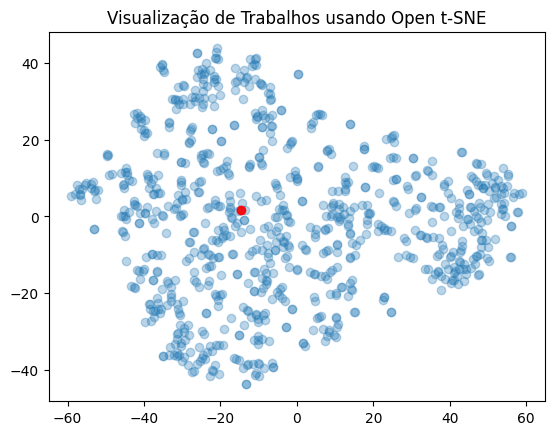

In [ ]:
x = [x for x,y in vis_dims_new]
y = [y for x,y in vis_dims_new]
plt.scatter(x, y, alpha=0.3)
plt.scatter(two_dimensions[0][0], two_dimensions[0][1], c='red',alpha=0.9)
plt.title("Visualização de Trabalhos usando Open t-SNE")

In [ ]:
import plotly.graph_objs as go

x = [x for x, y in vis_dims_new]
y = [y for x, y in vis_dims_new]


# Criar o gráfico de dispersão principal
scatter = go.Scatter(x=x, y=y, mode='markers', marker=dict(opacity=0.3),
                     text=df.titulo, hoverinfo='text', name="Todos os trabalhos")

# Adicionar o ponto azul
red_dot = go.Scatter(x=[two_dimensions[0][0]], y=[two_dimensions[0][1]], mode='markers',
                      marker=dict(color='red', opacity=0.9), text= paper.split(".", 1)[0],
                      hoverinfo='text', name="Referência")

# Criar um layout para o gráfico
layout = go.Layout(title="Visualização de Trabalhos usando Open t-SNE")

# Combina os elementos do gráfico e exibe o resultado
fig = go.Figure(data=[scatter, red_dot], layout=layout)
fig.show()

#Consulta 2

In [ ]:
!pip install opentsne
from sklearn.manifold import TSNE
import openTSNE
import matplotlib.pyplot as plt

In [ ]:
datafile_path = "publicacoes_ppgeec_embeddings.csv"
df = pd.read_csv(datafile_path)

In [ ]:
df["embedding"] = df.embedding.apply(eval).apply(np.array)

In [ ]:
def search_papers(dataframe, paper_description, n=3, pprint=True):
    df = dataframe.copy()
    paper_embedding = get_embedding(paper_description,
                                    engine="text-embedding-ada-002"
                                    )
    results = pd.DataFrame()
    df["similaridade"] = df.embedding.apply(lambda x: cosine_similarity(x, paper_embedding))
    results = df.sort_values("similaridade", ascending=False).head(n).combinacao.str.replace("Titulo: ", "").str.replace("; Resumo:", ": ")

    return results

In [ ]:
paper = """Esse trabalho tem como objetivo implementar um sistema web para monitoramento e controle de segurança de um local utilizando múltiplos robôs.
  Na implementação, foram usadas tecnologias disponibilizadas pelo ROS - Robot Operating System - para simular um ambiente sendo patrulhado por robôs, bem
  como fazer todo o processo de comunicação entre uma interface web e o sistema. Primeiramente, foi desenvolvido um servidor para controlar as ações de segurança
  e realizar a comunicação com os robôs. Uma vez que o servidor estava pronto, uma interface web foi construída para poder interagir com o servidor
  e representar visualmente, em um navegador, as ações dos robôs e o mapa do sistema sendo patrulhado. Verificou-se que, com o avanço da comunicação,
  dos navegadores e dos sistemas web, é possível realizar todo o controle de segurança de um ambiente por meio do uso de robôs e de uma simples tela de
  computador ou de celular. Para a simulação, foi utilizado um software chamado Gazebo, com robôs do tipo turtlebot. O servidor foi desenvolvido usando a
  linguagem de programação Python. Por fim, na interface web foi utilizado a linguagem de programação JavaScript, bem como um servidor websocket e um
  protocolo chamado Rosbridge, para fazer a comunicação com o servidor.."""

result = search_papers(df,paper, 5, False)
result

502    Título: ﻿Um sistema de visão para navegação ro...
245    Título: Ambiente de desenvolvimentoweb multipl...
460    Título: Uma abordagem comportamental para inse...
672    Título: Uma arquitetura de sistema para criaçã...
173    Título: Localização de robôs móveis em ambient...
Name: combinacao, dtype: object

In [ ]:
result.loc[502]

'Título: \ufeffUm sistema de visão para navegação robusta de uma plataforma robótica semi-autônoma:  \ufeffGrandes esforços têm sido despendidos pela comunidade científica em tarefas de locomoção de robôs móveis. Para a execução deste tipo de tarefa, devemos desenvolver no robô a habilidade de navegação no ambiente de forma segura, isto é, sem que haja colisões contra objetos. Para que isto seja realizado, faz-se necessário implementar estratégias que possibilitem a detecção de obstáculos. Neste trabalho, abordamos este problema, propondo um sistema \t \r\ncapaz de coletar informações sensoriais e estimar a possibilidade de ocorrência de obstáculos no percurso de um robô móvel. Câmeras estéreo, posicionadas paralelamente uma à outra, numa estrutura acoplada ao robô, são empregadas como o dispositivo sensorial principal, pos-\t \r\nsibilitando a geração de um mapa de disparidades. Otimizações de código e uma estratégia de redução e abstração de dados são aplicadas às imagens, resultando

In [ ]:
result.loc[245]

'Título: Ambiente de desenvolvimentoweb multiplataforma configurável para robótica educacional:  Propomos um ambiente de desenvolvimento online multiplataforma configurável, desenvolvido\nespecificamente para aplicações de robótica educacional. O ambiente, que\nsurge como uma extensão do software RoboEduc, possibilita que a programação de diversos\nrobôs programáveis possa ser realizada utilizando a linguagem R-Educ. Tornamos\npossível que o usuário programe na linguagem R-Educ e que o seu código seja traduzido\npara uma linguagem cadastrada anteriormente, compilado e em seguida enviado e/ou executado\npelo robô. Para o desenvolvimento deste trabalho, realizamos inicialmente uma\npesquisa bibliográfica acerca das principais linguagens de programação utilizadas em robótica,\nbem como suas definições e paradigmas, a partir da qual foi possível definir um\nconjunto de padrões considerados importantes para a criação deste ambiente. Em seguida,\nna fase de desenvolvimento de software, foi i

In [ ]:
result.loc[460]

'Título: Uma abordagem comportamental para inserção de robôs em ambientes culturais:  Neste trabalho, propomos metodologias e ferramentas computacionais visando inserir robôs em ambientes culturais. O objetivo é que um robô localizado em um contexto real (espaço cultural) possa representar tanto um usuário conectado ao sistema via Internet (avatar real para o visitante virtual), como também ter seu avatar em um ambiente de Realidade Mista (avatar para o robô no ambiente virtual). Nesse sentido, o robô e seu avatar deixam de ser meros objetos, real e virtual, e passam a ter uma função mais importante no cenário, podendo interferir no processo e tomar decisões. Para que esse serviço possa ser disponibilizado, desenvolvemos um módulo composto por um robô, ferramentas de comunicação e provemos maneiras de realizar a integração entre este e o ambiente virtual, bem como implementamos um conjunto de comportamentos com a finalidade de controle do protótipo no seu ambiente real. Estudamos ferra

In [ ]:
result.loc[672]

'Título: Uma arquitetura de sistema para criação, programação e disponibilização de times de robôs para robótica educacional:  Esse trabalho aborda o problema da programação, controle e colaboração de times de\r\nrobôs. Sistemas baseados em conjunto de robôs atuando de forma colaborativa tem sido\r\nalvo de muitas pesquisas nos últimos anos. Devido a rápida disseminação de tecnologias\r\nem dispositivos móveis e Internet, bem como os benefícios que a robótica agrega à várias\r\naplicações do cotidiano, a tendência é que cada vez mais ela esteja presente nas mais\r\nvariadas atividades dos seres humanos. Para o caso dos sistemas compostos por dois ou\r\nmais robôs, há uma necessidade latente por pesquisas que viabilizem sua utilização por\r\nusuários finais sem, ou com quase nenhuma, experiência com programação ou robótica.\r\nDessa forma, este trabalho propõe uma arquitetura de sistema que permite a criação e\r\nprogramação de equipes com robôs acoplados (chamados aqui de times de robô

In [ ]:
result.loc[173]

'Título: Localização de robôs móveis em ambientes fechados utilizando câmeras montadas no teto:  Propomos um sistema de localização de robôs móveis em ambientes fechados utilizando a técnica de visão global. Uma aplicação pode ser em museus virtuais, que podem ser acessados por usuários do mundo inteiro, usando um avatar robótico, possibilitando ainda a esses mesmos usuários a oportunidade de estabelecer uma presença virtual dentro do museu real, a através de uma plataforma robótica móvel colocada dentro do espaço físico real, permitindo a esse usuário locomover-se virtualmente dentro do museu real. O sistema aqui proposto visa melhorar o processo de localização desse guia robótico dentro do ambiente interno, já que os sensores instalados no mesmo acumulam erros, sem contar o fato de que as constantes mudanças ocorridas nesse tipo de ambiente acaba muitas vezes por introduzir ainda mais erros, ou mesmo até invalidar os dados obtidos devido a um total bloqueio de um determinado sensor. 

## Gráficos - Funcionamento com t-SNE

In [ ]:
df.head()

In [ ]:
!pip install opentsne
from sklearn.manifold import TSNE
import openTSNE
import matplotlib.pyplot as plt

In [ ]:
datafile_path = "publicacoes_ppgeec_embeddings.csv"
df = pd.read_csv(datafile_path)

# Convert to a list of lists of floats
matrix = np.array(df.embedding.apply(eval).to_list())

In [ ]:
matrix.shape

(850, 1536)

In [ ]:
# https://github.com/pavlin-policar/openTSNE

# Create a t-SNE model and transform the data into only two components
tsne_new = openTSNE.TSNE(n_components=2, perplexity=15, random_state=42,learning_rate=200)
vis_dims_new = tsne_new.fit(matrix)

In [ ]:
paper = """Esse trabalho tem como objetivo implementar um sistema web para monitoramento e controle de segurança de um local utilizando múltiplos robôs.
  Na implementação, foram usadas tecnologias disponibilizadas pelo ROS - Robot Operating System - para simular um ambiente sendo patrulhado por robôs, bem
  como fazer todo o processo de comunicação entre uma interface web e o sistema. Primeiramente, foi desenvolvido um servidor para controlar as ações de segurança
  e realizar a comunicação com os robôs. Uma vez que o servidor estava pronto, uma interface web foi construída para poder interagir com o servidor
  e representar visualmente, em um navegador, as ações dos robôs e o mapa do sistema sendo patrulhado. Verificou-se que, com o avanço da comunicação,
  dos navegadores e dos sistemas web, é possível realizar todo o controle de segurança de um ambiente por meio do uso de robôs e de uma simples tela de
  computador ou de celular. Para a simulação, foi utilizado um software chamado Gazebo, com robôs do tipo turtlebot. O servidor foi desenvolvido usando a
  linguagem de programação Python. Por fim, na interface web foi utilizado a linguagem de programação JavaScript, bem como um servidor websocket e um
  protocolo chamado Rosbridge, para fazer a comunicação com o servidor."""

In [ ]:
paper_embedding = get_embedding(paper,engine="text-embedding-ada-002")

In [ ]:
# Place this new embedding into all dataset
paper_embedding = np.array(paper_embedding)
paper_embedding = paper_embedding.reshape(1, -1)
two_dimensions = vis_dims_new.transform(paper_embedding)

Text(0.5, 1.0, 'Visualização de Trabalhos usando Open t-SNE')

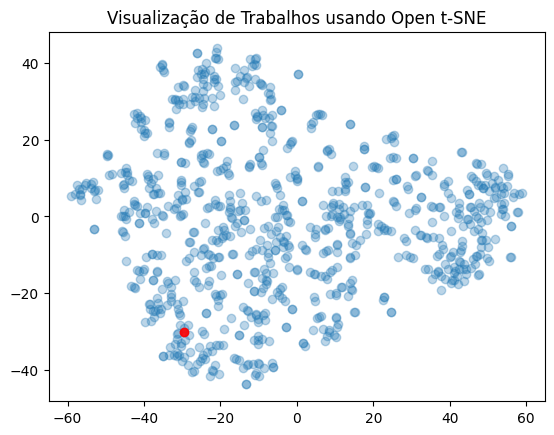

In [ ]:
x = [x for x,y in vis_dims_new]
y = [y for x,y in vis_dims_new]
plt.scatter(x, y, alpha=0.3)
plt.scatter(two_dimensions[0][0], two_dimensions[0][1], c='red',alpha=0.9)
plt.title("Visualização de Trabalhos usando Open t-SNE")

In [ ]:
import plotly.graph_objs as go

x = [x for x, y in vis_dims_new]
y = [y for x, y in vis_dims_new]


# Criar o gráfico de dispersão principal
scatter = go.Scatter(x=x, y=y, mode='markers', marker=dict(opacity=0.3),
                     text=df.titulo, hoverinfo='text', name="Todos os trabalhos")

# Adicionar o ponto azul
red_dot = go.Scatter(x=[two_dimensions[0][0]], y=[two_dimensions[0][1]], mode='markers',
                      marker=dict(color='red', opacity=0.9), text= paper.split(".", 1)[0],
                      hoverinfo='text', name="Referência")

# Criar um layout para o gráfico
layout = go.Layout(title="Visualização de Trabalhos usando Open t-SNE")

# Combina os elementos do gráfico e exibe o resultado
fig = go.Figure(data=[scatter, red_dot], layout=layout)
fig.show()